### Set up the Environment

In [1]:
import numpy as np
import cv2 as cv
import math
import matplotlib.pyplot as plt
from scipy.linalg import svd
from IPython.core.debugger import set_trace

### Read the left and right image

In [2]:
imgL = cv.imread("images/image_left.jpg")
gray1 = cv.cvtColor(imgL, cv.COLOR_BGR2GRAY)

In [3]:
imgR = cv.imread("images/image_right.jpg")
gray2 = cv.cvtColor(imgR, cv.COLOR_BGR2GRAY)

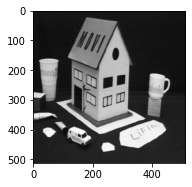

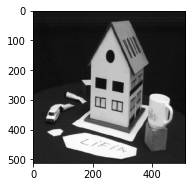

(<AxesSubplot:>, <matplotlib.image.AxesImage at 0x7f38ed34a710>, None)

In [4]:
plt.subplot(121), plt.imshow(imgL), plt.show()
plt.subplot(122), plt.imshow(imgR), plt.show()

### Read the left and right image coordinates from the given text files

In [5]:
def get_coordinates(filename):
    with open(filename,'r+') as f:
        lines = f.read().splitlines()
    coordinates = []
    for l in lines:
        v, u = l.split()
        coordinates.append((float(u), float(v)))
    return coordinates

In [6]:
kps1 = get_coordinates("images/pt_2D_left.txt")
kps2 = get_coordinates("images/pt_2D_right.txt")
print("Left and right image keypoints are: ", len(kps1), len(kps2))

Left and right image keypoints are:  37 37


### Test the correspondances

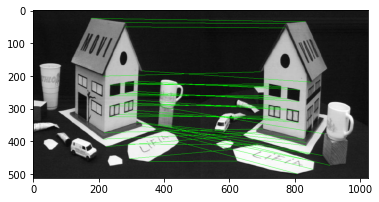

In [7]:
(hA, wA) = imgL.shape[:2]
(hB, wB) = imgR.shape[:2]
vis = np.zeros((max(hA, hB), wA + wB, 3), dtype="uint8")
vis[0:hA, 0:wA] = imgL
vis[0:hB, wA:] = imgR

for ((x1, y1), (x2, y2)) in zip(kps1, kps2):
    ptA = (int(x1), int(y1))
    ptB = (int(x2) + wA, int(y2))
    cv.line(vis, ptA, ptB, (0, 255, 0), 1)
    
plt.imshow(vis), plt.show
_ = cv.imwrite("results/given_correspondances_vis.jpg", vis)

## Estimating Fundamental Matrix using Normalized 8-Point Algorithm

In [8]:
# Convert to homogenous coordinates
kps1 = np.concatenate((kps1,np.ones((len(kps1),1))), axis = 1)
kps2 = np.concatenate((kps2,np.ones((len(kps2),1))), axis = 1)

In [9]:
def normalize_points(kps):
    mean = np.mean(kps, axis=0)
    centered = kps - mean * np.ones(kps.shape)      
    squared = centered * centered
    distance = np.sqrt(squared[:, 0] + squared[:, 1])
    std = np.mean(distance)
    Tr1 = np.array([[1, 0, -mean[0]], [0, 1, -mean[1]], [0, 0, 1]])
    Tr2 = np.array([[math.sqrt(2) / std, 0, 0], [0, math.sqrt(2) / std, 0], [0, 0, 1]])
    Tr = Tr2 @ Tr1
    return ((Tr @ kps.T).T, Tr)

In [10]:
p1, Tr_p1 = normalize_points(kps1)
p2, Tr_p2 = normalize_points(kps2)

In [11]:
def estimate_fundamental_matrix(p1, p2):
    # Linear Solution
    A_list = []
    for i in range(p1.shape[0]):
        u1 = p1[i][0]
        v1 = p1[i][1]
        u2 = p2[i][0]
        v2 = p2[i][1]
        
        # u1u1' v1u1' u1' u1v1' v1v1' v1' u1 v1 1
        # u1u2  v1u2  u2  u1v2  v1v2  v2  u1 v1 1
        A_list.append([u1*u2, v1*u2, u2, u1*v2, v1*v2, v2, u1, v1, 1])
    A = np.array(A_list)
    _, _, Vt = svd(A, full_matrices=False, overwrite_a=True)
    f = Vt[-1].reshape(3,3)

    # Enforce 2-rank constraint
    s, v, d = svd(f, full_matrices=False, overwrite_a=True)
    f_hat = s @ np.diag([*v[:2], 0]) @ d
    print("Determinant of f_hat is: ", np.linalg.det(f_hat))
    return f_hat

In [12]:
f_hat = estimate_fundamental_matrix(p1, p2)
# f_hat = estimate_fundamental_matrix(kps1, kps2)

Determinant of f_hat is:  -6.970871836051657e-19


In [13]:
F = Tr_p2.T @ f_hat @ Tr_p1

In [14]:
F

array([[ 7.69564303e-07, -5.78773950e-06, -1.01011620e-03],
       [-6.28660670e-06, -4.01132413e-07,  1.04176782e-02],
       [ 1.04182564e-04, -7.58583623e-03,  1.72255185e-01]])

### Visualise the Epipolar Lines

In [15]:
def drawlines(img1,img2,lines,pts1,pts2):
    ''' img1 - image on which we draw the epilines for the points in img2
        lines - corresponding epilines '''
    r,c, _ = img1.shape
    for r,pt1,pt2 in zip(lines,pts1,pts2):
        color = tuple(np.random.randint(0,255,3).tolist())
        x0,y0 = map(int, [0, -r[2]/r[1] ])
        x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
        img1 = cv.line(img1, (x0,y0), (x1,y1), color,1)
        img1 = cv.circle(img1,tuple(pt1),5,color,-1)
        img2 = cv.circle(img2,tuple(pt2),5,color,-1)
    return img1,img2

In [16]:
def vis_epipolar_lines(kps1, kps2, F, imgL, imgR, tag):
    
    pts1 = np.int32(kps1[:, 0:2])
    pts2 = np.int32(kps2[:, 0:2])

    # Find epilines corresponding to points in right image (second image) and
    # drawing its lines on left image
    lines1 = cv.computeCorrespondEpilines(pts2.reshape(-1,1,2), 2,F)
    lines1 = lines1.reshape(-1,3)
    img5,img6 = drawlines(imgL,imgR,lines1,pts1,pts2)

    lines2 = cv.computeCorrespondEpilines(pts1.reshape(-1,1,2), 1,F)
    lines2 = lines2.reshape(-1,3)
    img3,img4 = drawlines(imgR,imgL,lines2,pts2,pts1)

    plt.subplot(121),plt.imshow(img5)
    plt.subplot(122),plt.imshow(img3)
    plt.show()
    
    _ = cv.imwrite("results/left_epilines_"+tag+".jpg", img5)
    _ = cv.imwrite("results/right_epilines_"+tag+".jpg", img3)
    
    return lines1, lines2

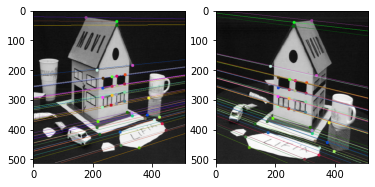

In [17]:
lines1, lines2 = vis_epipolar_lines(kps1, kps2, F, imgL, imgR, tag="custom")

## Estimate the error

In [18]:
def line_to_point_distance(point, line):
    (a, b, c) = line
    (u, v, _) = point
    return np.abs(a*u + b*v + c/np.sqrt(a*a + b*b))

In [19]:
def avg_epipolar_dist(points, lines):
    distance = 0
    for i in range(points.shape[0]):
        distance = distance + line_to_point_distance(points[i], lines[i])
    return distance/points.shape[0]

In [20]:
print("Estimation Error(image 1):", avg_epipolar_dist(kps1, lines1))
print("Estimation Error(image 2):", avg_epipolar_dist(kps2, lines2))

Estimation Error(image 1): 0.8286716389841439
Estimation Error(image 2): 0.9621440339330081


## Test the performance with noise in the image point correspondences

In [21]:
# Add noise of Gaussian distribution with given mean and standard deviation
def generate_noisy_2d_points(x, mean, std_dev):
    noise = np.random.normal(mean, std_dev, x.shape)
    noisy_x = x + noise
    return np.concatenate((noisy_x, np.ones((x.shape[0], 1))), axis=1)

In [22]:
std_dev_list = [0.5, 1, 1.5, 2]

For noisy points:
========With Noise of mean:0 and std dev: 0.5 :==========
Determinant of f_hat is:  1.4523610365061156e-18


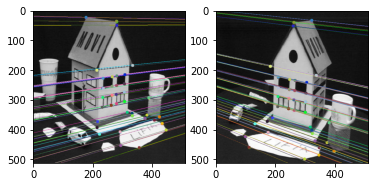

Estimation Error(image 1): 1.0465617674761174
Estimation Error(image 2): 1.3133866059127262
========With Noise of mean:0 and std dev: 1 :==========
Determinant of f_hat is:  0.0


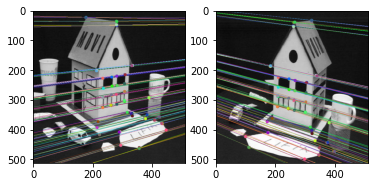

Estimation Error(image 1): 1.3727946523548011
Estimation Error(image 2): 1.5206510161292826
========With Noise of mean:0 and std dev: 1.5 :==========
Determinant of f_hat is:  6.250997125736132e-19


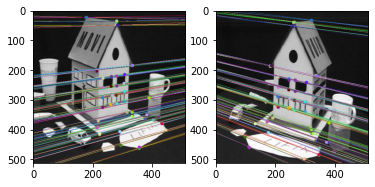

Estimation Error(image 1): 1.867286129453689
Estimation Error(image 2): 2.1026395274878804
========With Noise of mean:0 and std dev: 2 :==========
Determinant of f_hat is:  -1.5837940811886987e-18


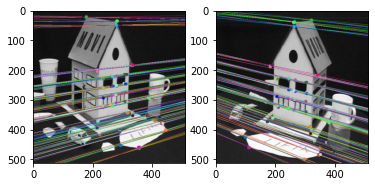

Estimation Error(image 1): 2.1684909236548258
Estimation Error(image 2): 2.445097476940963


In [23]:
print("For noisy points:")
for i in range(len(std_dev_list)):
    deviation = std_dev_list[i]
    print("========With Noise of mean:0 and std dev:", deviation, ":==========")
    kps1_noisy = generate_noisy_2d_points(kps1[:, 0:2], 0, deviation)
    kps2_noisy = generate_noisy_2d_points(kps2[:, 0:2], 0, deviation)
    p1, Tr_p1 = normalize_points(kps1_noisy)
    p2, Tr_p2 = normalize_points(kps2_noisy)
    f_hat = estimate_fundamental_matrix(p1, p2)
    F = Tr_p2.T @ f_hat @ Tr_p1
    lines1, lines2 = vis_epipolar_lines(kps1_noisy, kps2_noisy, F, imgL, imgR,tag="std"+str(deviation))
    print("Estimation Error(image 1):", avg_epipolar_dist(kps1_noisy, lines1))
    print("Estimation Error(image 2):", avg_epipolar_dist(kps2_noisy, lines2))
    

# Estimation of the Fundamental Matrix with Detected and Described Features

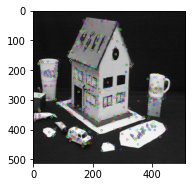

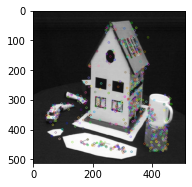

In [24]:
sift = cv.SIFT_create(contrastThreshold=0.02)
kps1, descs1 = sift.detectAndCompute(gray1,None)
kps2, descs2 = sift.detectAndCompute(gray2,None)
img1_kps=cv.drawKeypoints(gray1,kps1,imgL)
img2_kps=cv.drawKeypoints(gray2,kps2,imgR)

plt.subplot(121), plt.imshow(img1_kps), plt.show()
plt.subplot(122), plt.imshow(img2_kps), plt.show()
_ = cv.imwrite('results/sift_keypoints_left.jpg',img1_kps)
_ = cv.imwrite('results/sift_keypoints_right.jpg',img2_kps)

In [25]:
# FLANN parameters
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)
flann = cv.FlannBasedMatcher(index_params,search_params)
matches = flann.knnMatch(descs1,descs2,k=2)

pts1 = []
pts2 = []
# ratio test as per Lowe's paper
for i,(m,n) in enumerate(matches):
    if m.distance < 0.8*n.distance:
        pts2.append(kps2[m.trainIdx].pt)
        pts1.append(kps1[m.queryIdx].pt)

In [26]:
def convert_to_homogenous_coords(kps):
    points = []
    for i in range(len(kps)):
        points.append([kps[i][0], kps[i][1]])

    # Convert to homogenous coordinates
    return np.concatenate((points,np.ones((len(points),1))), axis = 1)

In [27]:
points1 = convert_to_homogenous_coords(pts1)
points2 = convert_to_homogenous_coords(pts2)

In [28]:
p1, Tr_p1 = normalize_points(points1)
p2, Tr_p2 = normalize_points(points2)

In [29]:
f_hat = estimate_fundamental_matrix(p1, p2)
Fcustom = Tr_p2.T @ f_hat @ Tr_p1

Determinant of f_hat is:  -1.55325336387624e-17


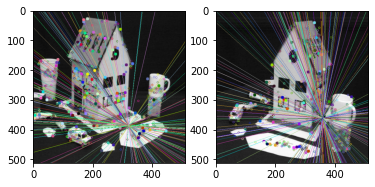

In [30]:
lines1, lines2 = vis_epipolar_lines(points1, points2, Fcustom, imgL, imgR, tag="sift")

In [31]:
print("Estimation Error(image 1):", avg_epipolar_dist(points1, lines1))
print("Estimation Error(image 2):", avg_epipolar_dist(points2, lines2))

Estimation Error(image 1): 90.31432985942533
Estimation Error(image 2): 73.70014779265789
